In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns


# Data Clean

In this section, we need to clean data: find null/NaN values; impute empty values, format variable types, detect outliers and so on.

In [ ]:
# Here, when I import data, I receive some unknown columns which should be removed.
trans_data=pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='Transactions',skiprows=1)
trans_data=trans_data.drop(columns=['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25'])
New_Cus = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='NewCustomerList',skiprows=1)
New_Cus=New_Cus.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20'])
Cus_Demo = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerDemographic',skiprows=1,index_col=0)
Cus_Demo=Cus_Demo.drop(columns=['Unnamed: 13','Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'])
Cus_Addr = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerAddress',skiprows=1,index_col=0)
Cus_Addr=Cus_Addr.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25'])

## Clean Transaction Data

In [ ]:
# deal with null value
#less than 1% of transactions (totalling less than 0.1% of revenue) have missing fields. These records have been removed from the training dataset.

trans_data['first_invoice_date']=trans_data.groupby('customer_id').transaction_date.transform('min')
trans_data["Lifetime"] = (datetime.datetime(2017,12,31) - trans_data["first_invoice_date"]) / np.timedelta64(1, 'D')

trans_data['product_first_sold_date'] =datetime.datetime(1900,1,1)+trans_data.product_first_sold_date.apply(lambda x: pd.Timedelta(x,unit='D'))
trans_data =trans_data.dropna()
trans_data.sort_values(by='customer_id')
#trans_data.describe

## Clean Customer Demographic Data

In [ ]:
# the default columes contains so much irrelevent data so we drop the colume.
Cus_Demo=Cus_Demo.drop(columns='default')

In [ ]:
Cus_Demo['job_title']=Cus_Demo['job_title'].fillna('Unavailable')
Cus_Demo['job_industry_category']=Cus_Demo['job_industry_category'].fillna('Unavailable')
Cus_Demo['job_industry_category'].replace('n/a','Unavailable')
Cus_Demo['last_name']=Cus_Demo['last_name'].fillna('AA') 
Cus_Demo['tenure']=Cus_Demo['tenure'].fillna(Cus_Demo.tenure.mode()[0])

Cus_Demo['DOB']=pd.to_datetime(Cus_Demo['DOB'])
Cus_Demo= Cus_Demo[Cus_Demo['DOB'] != Cus_Demo.DOB.min()]

In [ ]:
Cus_Demo.DOB.min()

In [ ]:
# there are a little bit in inbalance of gender, so I make the 'U' value to Male
Cus_Demo['gender']=Cus_Demo.gender.replace({'bfill':'Male','F':'Female','M':'Male','Femal':'Female'})
Cus_Demo['owns_car'] =Cus_Demo['owns_car'].map(dict(Yes=1,No=0))

In [ ]:
Cus_Demo['age']=round(np.ceil((datetime.datetime.now()-Cus_Demo['DOB'])/np.timedelta64(1,'Y')),0)

In [ ]:
Cus_Demo['age'].dropna().sort_values()

In [ ]:
Cus_Demo['age_group']=pd.cut(Cus_Demo['age'], bins=[20,30,40,50,60,70,100],labels=["20-30","30-40","40-50","50-60",'60-70','70-100'])
Cus_Demo=Cus_Demo.dropna()
Cus_Demo

## Clean Customer Address Data¶

In [878]:
Cus_Addr['state']=Cus_Addr['state'].replace('New South Wales','NSW')
Cus_Addr['state']=Cus_Addr['state'].replace('Victoria','VIC')
Cus_Addr.isnull().sum()

address               0
postcode              0
state                 0
country               0
property_valuation    0
dtype: int64

In [879]:
clean_demo_addr = pd.merge(Cus_Demo,Cus_Addr,left_index=True,right_index=True)
clean_demo_addr = clean_demo_addr.dropna()

## Clean New Customer Data

In [880]:
# same as above, make 'U' to 'Male' because the dataset has slightly less male customers
New_Cus['gender']=New_Cus['gender'].replace('U','Male')
New_Cus['age']=round(np.ceil((datetime.datetime.now()-New_Cus['DOB'])/np.timedelta64(1,'Y')),0)


In [881]:
New_Cus['age_group']=pd.cut(New_Cus['age'], bins=[20,30,40,50,60,70,100],labels=["20-30","30-40","40-50","50-60",'60-70','70-100'])
New_Cus=New_Cus.dropna()


# Data Exploration

## RMF Analysis

- Recency — number of days since the last purchase
- Frequency — number of transactions made over a given period
- Monetary — amount spent over a given period of time
        
Low recency, high frequency and high monetary value is the best condition
_____________________________________________

### Calculate RFM score and assign type

Convert absolute recency, frequency, and monetary values into relative ones to reduce the bias associated with the actual customer lifetime.
        
In terms of limited data that we only have data in 2017, I assume customers's life time began with the first transaction they took place in 2017

In [882]:
trans_data['profit']=trans_data['list_price']-trans_data['standard_cost']
trans_data['last_purchase_day_ago'] = trans_data['transaction_date'].max()-trans_data['transaction_date']
trans_data['last_purchase_day_ago'] =trans_data['last_purchase_day_ago']/np.timedelta64(1, 'D')
rfm = trans_data.groupby('customer_id').agg({'last_purchase_day_ago':'min','customer_id':'count','profit':'sum','Lifetime':'mean'})
rfm.columns = ['Recency','Frequency','Moneyness','Lifetime']
rfm["RelRecency"] = rfm["Recency"] / rfm["Lifetime"]
rfm["RelFrequency"] = rfm["Frequency"] / rfm["Lifetime"]
rfm["RelMoneyness"] = rfm['Moneyness']/rfm['Lifetime']
rfm

,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness
customer_id,,,,,,,
1,7.0,11,3018.090000,360.0,0.019444,0.030556,8.383583
2,128.0,3,2226.260000,241.0,0.531120,0.012448,9.237593
3,102.0,7,3290.210000,311.0,0.327974,0.022508,10.579453
4,195.0,2,220.570000,272.0,0.716912,0.007353,0.810919
5,16.0,6,2394.940000,303.0,0.052805,0.019802,7.904092
...,...,...,...,...,...,...,...
3497,52.0,3,1648.320000,121.0,0.429752,0.024793,13.622479
3498,127.0,6,3147.330000,331.0,0.383686,0.018127,9.508550
3499,51.0,7,4955.250000,353.0,0.144476,0.019830,14.037535


In [883]:
#Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.
rfm['r_quartile'] = pd.qcut(rfm['RelRecency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['RelFrequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['RelMoneyness'], 4, ['4','3','2','1'])
rfm

,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness,r_quartile,f_quartile,m_quartile
customer_id,,,,,,,,,,
1,7.0,11,3018.090000,360.0,0.019444,0.030556,8.383583,1,1,3
2,128.0,3,2226.260000,241.0,0.531120,0.012448,9.237593,4,4,3
3,102.0,7,3290.210000,311.0,0.327974,0.022508,10.579453,4,2,2
4,195.0,2,220.570000,272.0,0.716912,0.007353,0.810919,4,4,4
5,16.0,6,2394.940000,303.0,0.052805,0.019802,7.904092,1,2,3
...,...,...,...,...,...,...,...,...,...,...
3497,52.0,3,1648.320000,121.0,0.429752,0.024793,13.622479,4,1,2
3498,127.0,6,3147.330000,331.0,0.383686,0.018127,9.508550,4,2,2
3499,51.0,7,4955.250000,353.0,0.144476,0.019830,14.037535,2,2,1


In [884]:
rfm['RFM_Score'] = pd.to_numeric(rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str))
rfm['total_score'] = pd.to_numeric(rfm['r_quartile'].astype(int) + rfm['f_quartile'].astype(int) + rfm['m_quartile'].astype(int))
rfm.head()

,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness,r_quartile,f_quartile,m_quartile,RFM_Score,total_score
customer_id,,,,,,,,,,,,
1,7.0,11,3018.09,360.0,0.019444,0.030556,8.383583,1,1,3,113,5
2,128.0,3,2226.26,241.0,0.531120,0.012448,9.237593,4,4,3,443,11
3,102.0,7,3290.21,311.0,0.327974,0.022508,10.579453,4,2,2,422,8
4,195.0,2,220.57,272.0,0.716912,0.007353,0.810919,4,4,4,444,12
5,16.0,6,2394.94,303.0,0.052805,0.019802,7.904092,1,2,3,123,6


In [885]:
rfm[rfm['RFM_Score']==111].sort_values('Moneyness', ascending=False)

,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness,r_quartile,f_quartile,m_quartile,RFM_Score,total_score
customer_id,,,,,,,,,,,,
1460,12.0,8,10787.60,325.0,0.036923,0.024615,33.192615,1,1,1,111,3
1558,8.0,9,10640.30,303.0,0.026403,0.029703,35.116502,1,1,1,111,3
322,1.0,11,10336.77,356.0,0.002809,0.030899,29.035871,1,1,1,111,3
195,0.0,7,9633.41,298.0,0.000000,0.023490,32.326879,1,1,1,111,3
729,1.0,9,8953.17,291.0,0.003436,0.030928,30.766907,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2693,1.0,6,2772.31,103.0,0.009709,0.058252,26.915631,1,1,1,111,3
2611,2.0,7,2609.86,183.0,0.010929,0.038251,14.261530,1,1,1,111,3
3395,9.0,7,2586.85,177.0,0.050847,0.039548,14.614972,1,1,1,111,3


In [886]:
rfm_quartiles = (rfm['RFM_Score'].min(), rfm['RFM_Score'].quantile(q=0.25),
                 rfm['RFM_Score'].median(), rfm['RFM_Score'].quantile(q=0.75), 
                 rfm['RFM_Score'].max())
rfm_quartiles

(111, 194.25, 277.5, 360.75, 444)

Classify Customers based on their RFM quantile into GOLD, SILVER, BRONZE and NORMAL.

In [887]:
conditions =[
    (rfm['RFM_Score']<=rfm_quartiles[1]),
    ((rfm['RFM_Score']>rfm_quartiles[1]) & (rfm['RFM_Score'] <=rfm_quartiles[2])),
    ((rfm['RFM_Score']>rfm_quartiles[2]) & (rfm['RFM_Score'] <= rfm_quartiles[3])),
    (rfm['RFM_Score']>rfm_quartiles[3])
]
values = ['Gold','Silver','Bronze','Normal']

rfm['Type']= np.select(conditions,values)

In [888]:
rfm

,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness,r_quartile,f_quartile,m_quartile,RFM_Score,total_score,Type
customer_id,,,,,,,,,,,,,
1,7.0,11,3018.090000,360.0,0.019444,0.030556,8.383583,1,1,3,113,5,Gold
2,128.0,3,2226.260000,241.0,0.531120,0.012448,9.237593,4,4,3,443,11,Normal
3,102.0,7,3290.210000,311.0,0.327974,0.022508,10.579453,4,2,2,422,8,Normal
4,195.0,2,220.570000,272.0,0.716912,0.007353,0.810919,4,4,4,444,12,Normal
5,16.0,6,2394.940000,303.0,0.052805,0.019802,7.904092,1,2,3,123,6,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,52.0,3,1648.320000,121.0,0.429752,0.024793,13.622479,4,1,2,412,7,Normal
3498,127.0,6,3147.330000,331.0,0.383686,0.018127,9.508550,4,2,2,422,8,Normal
3499,51.0,7,4955.250000,353.0,0.144476,0.019830,14.037535,2,2,1,221,5,Silver


In [889]:
rfm["Recency"].describe()

count    3492.000000
mean       62.495991
std        59.190890
min         0.000000
25%        18.000000
50%        45.000000
75%        88.000000
max       353.000000
Name: Recency, dtype: float64

In [890]:
rfm["RelRecency"].describe()

count    3492.000000
mean        0.218962
std         0.216578
min         0.000000
25%         0.058598
50%         0.151193
75%         0.304639
max         0.997175
Name: RelRecency, dtype: float64

In [891]:
nn = sum(rfm["RelRecency"]==0) / len(rfm)
print(f"This shows that {round(nn*100,2)}% customers only had one transactions.")

This shows that 1.29% customers only had one transactions.


In [892]:
rfm["RelFrequency"].describe()

count    3492.000000
mean        0.018768
std         0.008261
min         0.002770
25%         0.013736
50%         0.017699
75%         0.022951
max         0.200000
Name: RelFrequency, dtype: float64

In [893]:
np.percentile(rfm["Moneyness"], 99)

8149.903300000011

<AxesSubplot:>

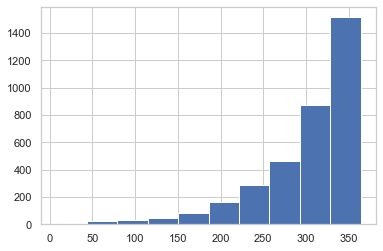

In [894]:
rfm["Lifetime"].hist()

### Recency, Frequency and MoneyValue Distribution

<ipython-input-895-82feb54dbb74>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


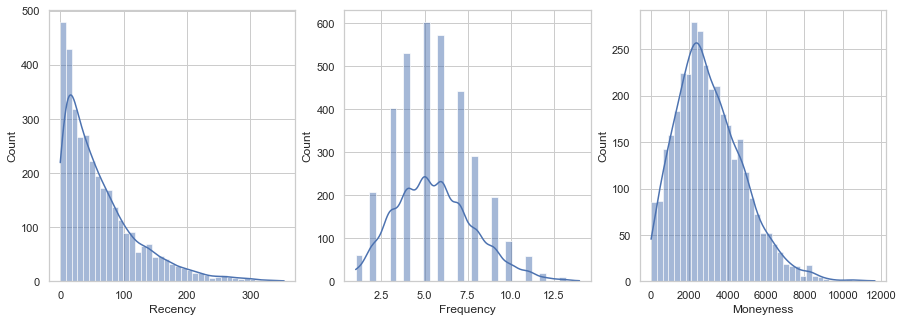

In [895]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(x='Recency', kde=True,data=rfm, ax=axs[0])
sns.histplot(x='Frequency', kde=True,data=rfm, ax=axs[1])
sns.histplot(x='Moneyness', kde=True,data=rfm, ax=axs[2])
fig.show()

Text(0.5, 1.0, 'RFM_Score')

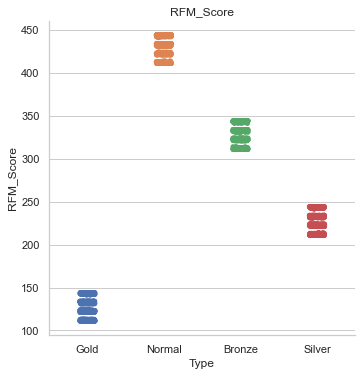

In [896]:
sns.catplot(x='Type',y='RFM_Score',data=rfm)
plt.title('RFM_Score')

In [897]:
# rfm['RecencyScore'] = pd.cut(rfm["Recency"], 
#                                        bins=[-1, 
#                                              np.percentile(rfm["Recency"], 25), 
#                                              np.percentile(rfm["Recency"], 50), 
#                                              np.percentile(rfm["Recency"], 75), 
#                                              rfm["Recency"].max()], 
#                                        labels=[4, 3, 2, 1]).astype("int")
# rfm["RecencyScore"].value_counts()


# rfm["FrequencyScore"] = pd.cut(rfm["Frequency"], 
#                                        bins=[-1, 
#                                              np.percentile(rfm["Frequency"], 25), 
#                                              np.percentile(rfm["Frequency"], 50), 
#                                              np.percentile(rfm["Frequency"], 75), 
#                                              rfm["Frequency"].max()], 
#                                        labels=[1, 2, 3, 4]).astype("int")
# rfm["FrequencyScore"].value_counts()

# rfm["MoneynessScore"] = pd.cut(rfm["Moneyness"], 
#                                        bins=[rfm["Moneyness"].min()-1, 
#                                              np.percentile(rfm["Moneyness"], 25),
#                                              np.percentile(rfm["Moneyness"], 50), 
#                                              np.percentile(rfm["Moneyness"], 75), 
#                                              rfm["Moneyness"].max()], 
#                                        labels=[1, 2, 3, 4]).astype("int")
# rfm["MoneynessScore"].value_counts()

# rfm["RFM"] = rfm["RecencyScore"] + rfm["FrequencyScore"] + rfm["MoneynessScore"]


Text(0.5, 1.0, 'RFM Score')

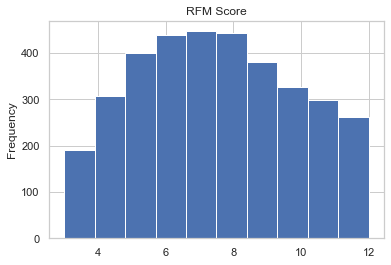

In [898]:
rfm["total_score"].plot(kind='hist')
plt.title('RFM Score')

In [899]:
rfm_abs = pd.DataFrame(rfm.pivot_table(index=["total_score"], 
                                    values=["Recency", "Frequency", "Moneyness", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "Moneyness": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_abs

Frequency             Lifetime                    Moneyness  \
                 amax amin median     amax  amin count median      amax   
total_score                                                               
3                  14    3      9    364.0  99.0   190  313.5  10787.60   
4                  13    2      8    364.0  64.0   307  318.0  11668.95   
5                  12    2      7    364.0  28.0   401  322.0  11222.65   
6                  13    1      6    364.0   8.0   438  320.5   8624.72   
7                  11    1      6    364.0  54.0   447  325.0   8330.09   
8                  10    1      5    364.0  35.0   443  325.0   6444.49   
9                   7    1      5    364.0  41.0   381  329.0   4829.40   
10                  7    1      4    364.0  49.0   326  321.0   4434.93   
11                  6    1      3    364.0  60.0   298  316.5   3405.10   
12                  4    1      2    364.0  75.0   261  311.0   2105.39   

                               Recency               
                amin    median    amax  amin median  
total_score                                          
3            1396.62  5506.345    21.0   0.0    7.0  
4            1182.38  4888.710    52.0   0.0   19.0  
5             308.78  4240.240   105.0   0.0   27.0  
6             451.65  3482.695   154.0   0.0   35.0  
7             409.80  3148.100   218.0   0.0   42.0  
8             263.54  2515.430   246.0   0.0   47.0  
9              64.51  2188.450   293.0   0.0   60.0  
10            133.38  1835.325   278.0  16.0   69.5  
11             35.74  1594.295   295.0  34.0  107.5  
12             15.08   869.320   353.0  74.0  168.0

In [900]:
# rfm['RecencyScore'] = pd.cut(rfm["RelRecency"], 
#                                        bins=[-1, 
#                                              np.percentile(rfm["RelRecency"], 25), 
#                                              np.percentile(rfm["RelRecency"], 50), 
#                                              np.percentile(rfm["RelRecency"], 75), 
#                                              rfm["RelRecency"].max()], 
#                                        labels=[4, 3, 2, 1]).astype("int")
# rfm["RecencyScore"].value_counts()


# rfm["FrequencyScore"] = pd.cut(rfm["RelFrequency"], 
#                                        bins=[-1, 
#                                              np.percentile(rfm["RelFrequency"], 25), 
#                                              np.percentile(rfm["RelFrequency"], 50), 
#                                              np.percentile(rfm["RelFrequency"], 75), 
#                                              rfm["RelFrequency"].max()], 
#                                        labels=[1, 2, 3, 4]).astype("int")
# rfm["FrequencyScore"].value_counts()

# rfm["MoneynessScore"] = pd.cut(rfm["RelMoneyness"], 
#                                        bins=[rfm["RelMoneyness"].min()-1, 
#                                              np.percentile(rfm["RelMoneyness"], 25),
#                                              np.percentile(rfm["RelMoneyness"], 50), 
#                                              np.percentile(rfm["RelMoneyness"], 75), 
#                                              rfm["RelMoneyness"].max()], 
#                                        labels=[1, 2, 3, 4]).astype("int")
# rfm["MoneynessScore"].value_counts()

# rfm["RFM"] = rfm["RecencyScore"] + rfm["FrequencyScore"] + rfm["MoneynessScore"]
# rfm

In [948]:
def rfm_level(df):
    if df['total_score'] >= 9:
        return 'Require Activation'
    elif ((df['total_score'] >= 8) and (df['total_score'] < 9)):
        return 'Promising'
    elif ((df['total_score'] >= 7) and (df['total_score'] < 8)):
        return 'Potential'
    elif ((df['total_score'] >= 6) and (df['total_score'] < 7)):
        return 'Loyal'
    elif ((df['total_score'] >= 5) and (df['total_score'] < 6)):
        return 'Champions'
    elif ((df['total_score'] >= 4) and (df['total_score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Can\'t Loose Them'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm

,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness,r_quartile,f_quartile,m_quartile,RFM_Score,total_score,Type,RFM_Level,last_order_within_l60d,more_than_two_orders,value_higher_than_2k,RFM_Level2
customer_id,,,,,,,,,,,,,,,,,,
1,7.0,11,3018.090000,360.0,0.019444,0.030556,8.383583,1,1,3,113,5,Gold,Champions,True,True,True,High Engagement & High Value
2,128.0,3,2226.260000,241.0,0.531120,0.012448,9.237593,4,4,3,443,11,Normal,Require Activation,False,True,True,Old and High Frequency
3,102.0,7,3290.210000,311.0,0.327974,0.022508,10.579453,4,2,2,422,8,Normal,Promising,False,True,True,Old and High Frequency
4,195.0,2,220.570000,272.0,0.716912,0.007353,0.810919,4,4,4,444,12,Normal,Require Activation,False,False,False,Low Engagement & Low Value
5,16.0,6,2394.940000,303.0,0.052805,0.019802,7.904092,1,2,3,123,6,Gold,Loyal,True,True,True,High Engagement & High Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,52.0,3,1648.320000,121.0,0.429752,0.024793,13.622479,4,1,2,412,7,Normal,Potential,True,True,False,High Engagement & Low Value
3498,127.0,6,3147.330000,331.0,0.383686,0.018127,9.508550,4,2,2,422,8,Normal,Promising,False,True,True,Old and High Frequency
3499,51.0,7,4955.250000,353.0,0.144476,0.019830,14.037535,2,2,1,221,5,Silver,Champions,True,True,True,High Engagement & High Value


### Median Lifetime of RFM Segments (Absolute vs Relative)

In [902]:
rfm_rel = pd.DataFrame(rfm.pivot_table(index=["total_score"], 
                                    values=["Recency", "Frequency", "Moneyness", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "Moneyness": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_rel
# Note that the median lifetime is rather constant across clusters. This is a good news - our segmentation is not biased by the lifetime
# of the customers.

Frequency             Lifetime                    Moneyness  \
                 amax amin median     amax  amin count median      amax   
total_score                                                               
3                  14    3      9    364.0  99.0   190  313.5  10787.60   
4                  13    2      8    364.0  64.0   307  318.0  11668.95   
5                  12    2      7    364.0  28.0   401  322.0  11222.65   
6                  13    1      6    364.0   8.0   438  320.5   8624.72   
7                  11    1      6    364.0  54.0   447  325.0   8330.09   
8                  10    1      5    364.0  35.0   443  325.0   6444.49   
9                   7    1      5    364.0  41.0   381  329.0   4829.40   
10                  7    1      4    364.0  49.0   326  321.0   4434.93   
11                  6    1      3    364.0  60.0   298  316.5   3405.10   
12                  4    1      2    364.0  75.0   261  311.0   2105.39   

                               Recency               
                amin    median    amax  amin median  
total_score                                          
3            1396.62  5506.345    21.0   0.0    7.0  
4            1182.38  4888.710    52.0   0.0   19.0  
5             308.78  4240.240   105.0   0.0   27.0  
6             451.65  3482.695   154.0   0.0   35.0  
7             409.80  3148.100   218.0   0.0   42.0  
8             263.54  2515.430   246.0   0.0   47.0  
9              64.51  2188.450   293.0   0.0   60.0  
10            133.38  1835.325   278.0  16.0   69.5  
11             35.74  1594.295   295.0  34.0  107.5  
12             15.08   869.320   353.0  74.0  168.0

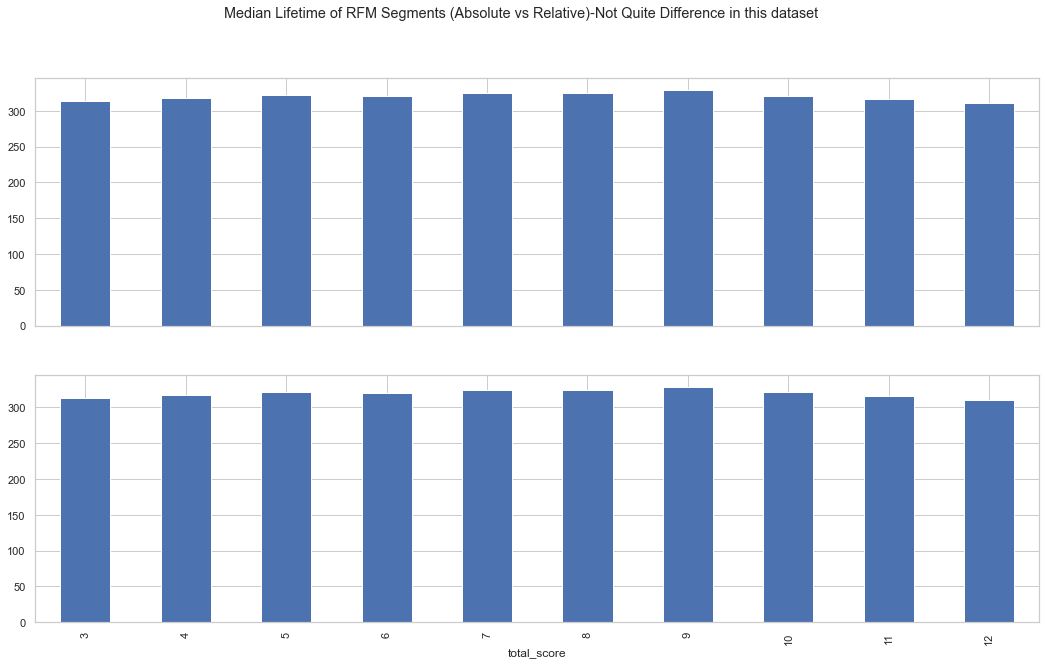

In [903]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(18,10),sharex=True)
fig.suptitle('Median Lifetime of RFM Segments (Absolute vs Relative)-Not Quite Difference in this dataset')
rfm_abs["Lifetime"]["median"].plot(ax=axes[0], kind="bar")
rfm_rel["Lifetime"]["median"].plot(ax=axes[1], kind="bar")
plt.show()

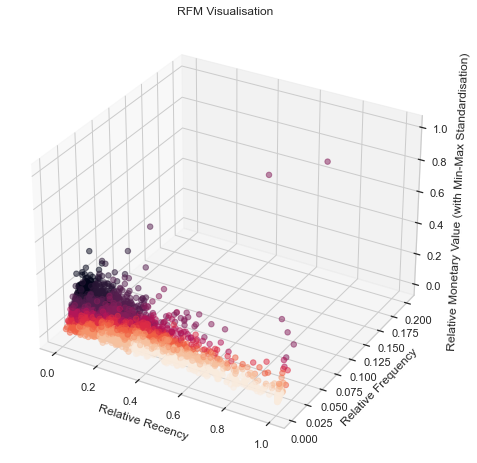

In [904]:
# Visualise segments using 3D plot
x = rfm["RelRecency"]
y = rfm["RelFrequency"]
z = (rfm["RelMoneyness"] - rfm["RelMoneyness"].min()) / rfm["RelMoneyness"].max()
c = rfm["total_score"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x, ys=y, zs=z, c=c, s=30, alpha=0.5)
ax.set_title("RFM Visualisation")
ax.set_xlabel("Relative Recency")
ax.set_ylabel("Relative Frequency")
ax.set_zlabel("Relative Monetary Value (with Min-Max Standardisation)")
plt.show()

In [905]:
correlation=rfm.iloc[:8].corr()
correlation.style.background_gradient(cmap='coolwarm',)


,Recency,Frequency,Moneyness,Lifetime,RelRecency,RelFrequency,RelMoneyness,RFM_Score,total_score
Recency,1.000000,-0.802515,-0.802597,-0.521862,0.987439,-0.831379,-0.784545,0.851687,0.929421
Frequency,-0.802515,1.000000,0.708955,0.789799,-0.841469,0.986557,0.621350,-0.779580,-0.913669
Moneyness,-0.802597,0.708955,1.000000,0.592596,-0.816436,0.710884,0.977057,-0.498663,-0.826468
Lifetime,-0.521862,0.789799,0.592596,1.000000,-0.630976,0.695388,0.424880,-0.622833,-0.742842
RelRecency,0.987439,-0.841469,-0.816436,-0.630976,1.000000,-0.857773,-0.776994,0.871867,0.959749
RelFrequency,-0.831379,0.986557,0.710884,0.695388,-0.857773,1.000000,0.653124,-0.769086,-0.909305
RelMoneyness,-0.784545,0.621350,0.977057,0.424880,-0.776994,0.653124,1.000000,-0.419779,-0.751641
RFM_Score,0.851687,-0.779580,-0.498663,-0.622833,0.871867,-0.769086,-0.419779,1.000000,0.873465
total_score,0.929421,-0.913669,-0.826468,-0.742842,0.959749,-0.909305,-0.751641,0.873465,1.000000


## Segmentation Analysis

### Number of Customers by level

#### Number of Customers by 5 Segment

In [906]:
rfm["last_order_within_l60d"] = rfm["Recency"]<60 # Had transactions in the last 60 days
rfm["more_than_two_orders"] = rfm["Frequency"]>2 # Logged in more than twice
rfm["value_higher_than_2k"] = rfm["Moneyness"]>2000 # Sum of value higher than 2K
rfm.groupby(["last_order_within_l60d", "more_than_two_orders", "value_higher_than_2k"]).count()["Lifetime"]

last_order_within_l60d  more_than_two_orders  value_higher_than_2k
False                   False                 False                    181
                                              True                      13
                        True                  False                    359
                                              True                     839
True                    False                 False                     69
                                              True                       5
                        True                  False                    406
                                              True                    1620
Name: Lifetime, dtype: int64

In [907]:
conditions = [
    (rfm["last_order_within_l60d"]==True)&(rfm["more_than_two_orders"]==True)&(rfm["value_higher_than_2k"]==True),
    (rfm["last_order_within_l60d"]==True)&(rfm["more_than_two_orders"]==True)&(rfm["value_higher_than_2k"]==False),
    (rfm["last_order_within_l60d"]==True)&(rfm["more_than_two_orders"]==False),
    (rfm["last_order_within_l60d"]==False)&(rfm["more_than_two_orders"]==True),
    (rfm["last_order_within_l60d"]==False)&(rfm["more_than_two_orders"]==False)
]
mappings = ["High Engagement & High Value", 
            "High Engagement & Low Value", 
            "Recent and Low Frequency", 
            "Old and High Frequency", 
            "Low Engagement & Low Value"]
rfm['RFM_Level2'] = np.select(conditions, mappings, default="Others")
segment_5= rfm['RFM_Level2'].value_counts().rename_axis('Customer Segments').reset_index(name='Number')
segment_5

,Customer Segments,Number
0,High Engagement & High Value,1620
1,Old and High Frequency,1198
2,High Engagement & Low Value,406
3,Low Engagement & Low Value,194
4,Recent and Low Frequency,74


Text(0.5, 1.0, 'Number of Customers by 5 Segment')

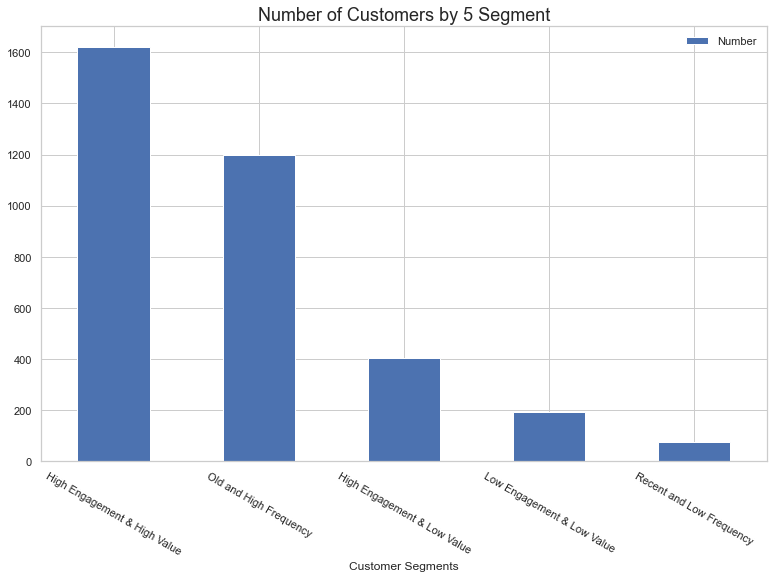

In [908]:
segment_5.plot(x='Customer Segments',y='Number',kind='bar',rot=-30,figsize=(13,8))
plt.title('Number of Customers by 5 Segment',fontsize=18)

#### Number of Customers by age

Text(0.5, 1.0, 'Number of Customers by age')

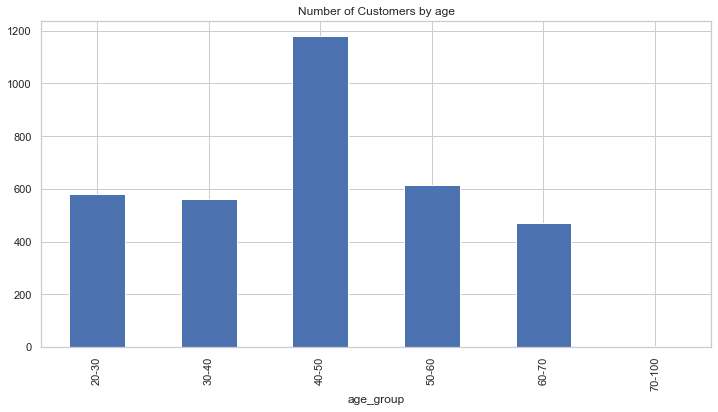

In [909]:
addr_demo_tran.groupby('age_group')['DOB'].count().plot(kind='bar',figsize=(12,6))
plt.title('Number of Customers by age')

### Profit

#### Profit by month

Text(0.5, 1.0, 'Profit per Month')

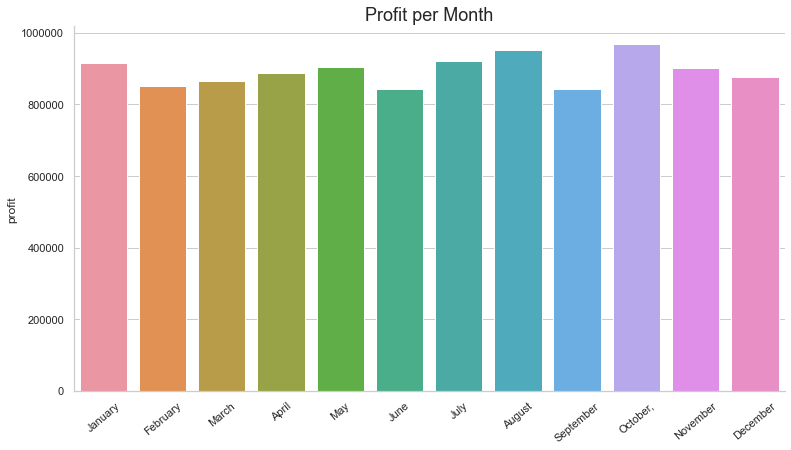

In [910]:
profit_per_day=trans_data.groupby('transaction_date')[['profit']].sum()
profit_per_week = profit_per_day.resample('W').sum()
profit_per_month=profit_per_day.resample('M').sum()
profit_per_month.index=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October,' ,'November','December']
profit_per_month

sns.set_theme(style="whitegrid")
ax = sns.catplot(x=profit_per_month.index, y="profit",kind='bar', data=profit_per_month)
ax.fig.set_figheight(6)
ax.fig.set_figwidth(12)
plt.xticks(rotation=40)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Profit per Month',fontsize=18)

#### Profit Contribution by Age Group

In [911]:
addr_demo_tran = pd.merge(clean_demo_addr,rfm,left_index=True,right_index=True)

addr_demo_tran = addr_demo_tran.drop(columns=['first_name','last_name','job_title','last_order_within_l60d','more_than_two_orders','value_higher_than_2k'])
addr_demo_tran

,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,age,age_group,...,RelFrequency,RelMoneyness,r_quartile,f_quartile,m_quartile,RFM_Score,total_score,Type,RFM_Level,RFM_Level2
customer_id,,,,,,,,,,,,,,,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,N,1,11.0,69.0,60-70,...,0.030556,8.383583,1,1,3,113,5,Gold,Champions,High Engagement & High Value
2,Male,81,1980-12-16,Financial Services,Mass Customer,N,1,16.0,42.0,40-50,...,0.012448,9.237593,4,4,3,443,11,Normal,Require Activation,Old and High Frequency
4,Male,33,1961-10-03,IT,Mass Customer,N,0,7.0,61.0,60-70,...,0.007353,0.810919,4,4,4,444,12,Normal,Require Activation,Low Engagement & Low Value
5,Female,56,1977-05-13,Unavailable,Affluent Customer,N,1,8.0,45.0,40-50,...,0.019802,7.904092,1,2,3,123,6,Gold,Loyal,High Engagement & High Value
6,Male,35,1966-09-16,Retail,High Net Worth,N,1,13.0,56.0,50-60,...,0.014837,11.710831,3,3,2,332,8,Bronze,Promising,Old and High Frequency
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,Male,99,1986-04-25,Manufacturing,Mass Customer,N,1,19.0,36.0,30-40,...,0.013378,6.842274,4,4,3,443,11,Normal,Require Activation,Old and High Frequency
3497,Female,73,1986-05-03,Manufacturing,Affluent Customer,N,1,18.0,36.0,30-40,...,0.024793,13.622479,4,1,2,412,7,Normal,Potential,High Engagement & Low Value
3498,Female,28,1995-11-02,Manufacturing,Mass Customer,N,0,5.0,27.0,20-30,...,0.018127,9.508550,4,2,2,422,8,Normal,Promising,Old and High Frequency


In [912]:
cupf=trans_data.groupby(['customer_id'])[['profit']].sum()
addr_demo_tran=addr_demo_tran.merge(cupf,on='customer_id')

Text(0.5, 1.0, 'Profit by Age Group')

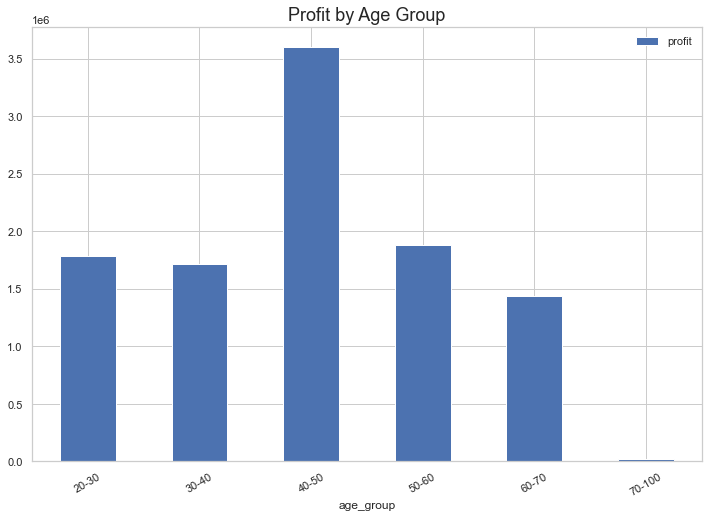

In [935]:
addr_demo_tran.groupby('age_group')[['profit']].sum().plot(kind='bar',rot=30,figsize=(12, 8))
plt.title("Profit by Age Group",fontsize=18)

#### Profit Contribution in Different Age and Type

In [914]:
addr_demo_tran.columns

Index(['gender', 'past_3_years_bike_related_purchases', 'DOB',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'age', 'age_group', 'address', 'postcode',
       'state', 'country', 'property_valuation', 'Recency', 'Frequency',
       'Moneyness', 'Lifetime', 'RelRecency', 'RelFrequency', 'RelMoneyness',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFM_Score', 'total_score',
       'Type', 'RFM_Level', 'RFM_Level2', 'profit'],
      dtype='object')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Bronze'),
  Text(1, 0, 'Gold'),
  Text(2, 0, 'Normal'),
  Text(3, 0, 'Silver')])

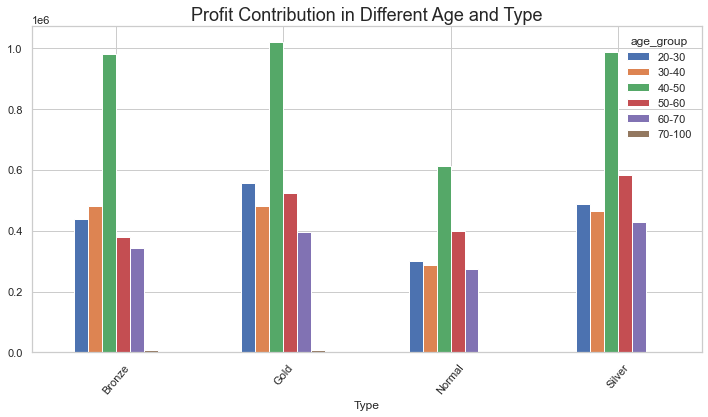

In [937]:
addr_demo_tran.groupby(['Type','age_group'])[['profit']].sum().unstack().plot(kind='bar',y='profit',figsize=(12, 6))
plt.title("Profit Contribution in Different Age and Type",fontsize=18)
plt.xticks(rotation=50)

### Customer Geographic

Text(0.5, 1.0, 'Customer Geographic')

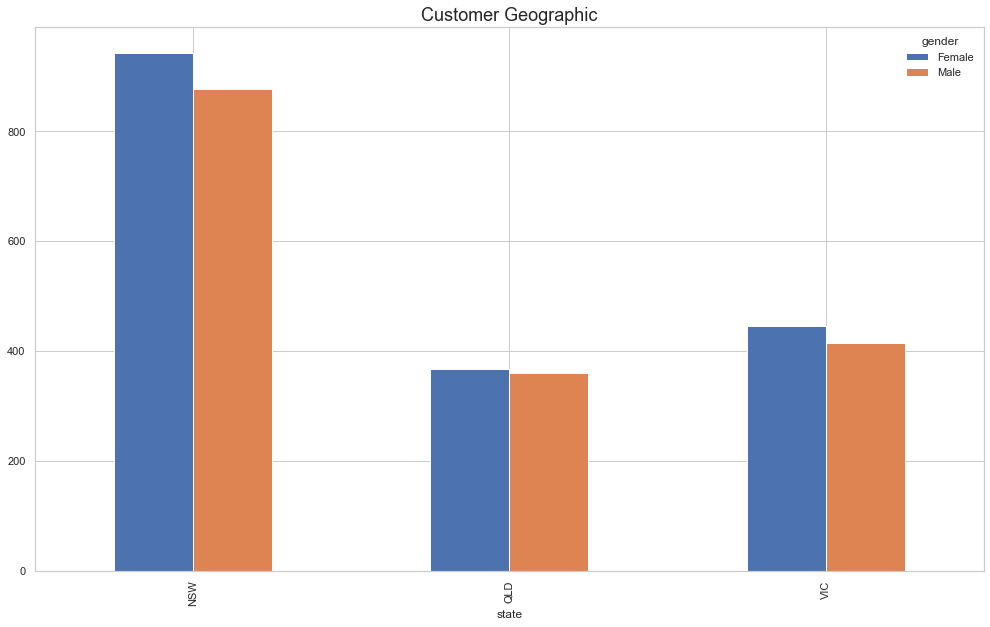

In [916]:
addr_demo_tran.groupby(['state','gender'])[['gender']].count().unstack().plot(kind='bar',y='gender',figsize=(17, 10))
plt.title("Customer Geographic",fontsize=18)

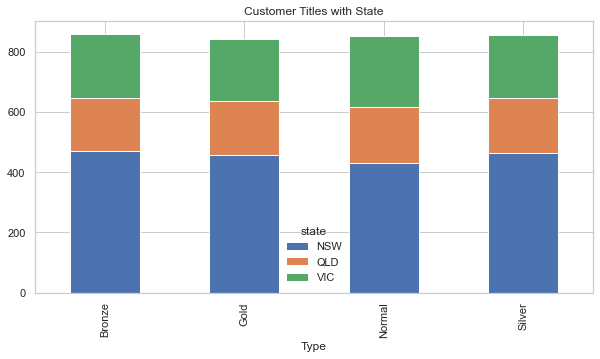

In [917]:
addr_demo_tran.groupby('Type')['state'].value_counts().unstack(level=1).plot.bar(stacked=True,figsize=(10,5))
plt.title('Customer Titles with State')
plt.show()

### Wealth Segment

Text(0.5, 1.0, 'Wealth Segment by Age Group')

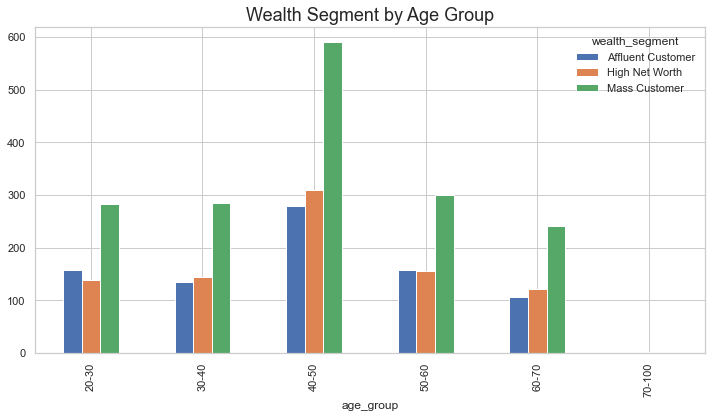

In [938]:
addr_demo_tran.groupby(['age_group','wealth_segment'])[['wealth_segment']].count().dropna().unstack().plot(kind='bar',y='wealth_segment',figsize=(12, 6))
plt.title("Wealth Segment by Age Group",fontsize=18)

Text(0.5, 1.0, 'Wealth Segment by Industry')

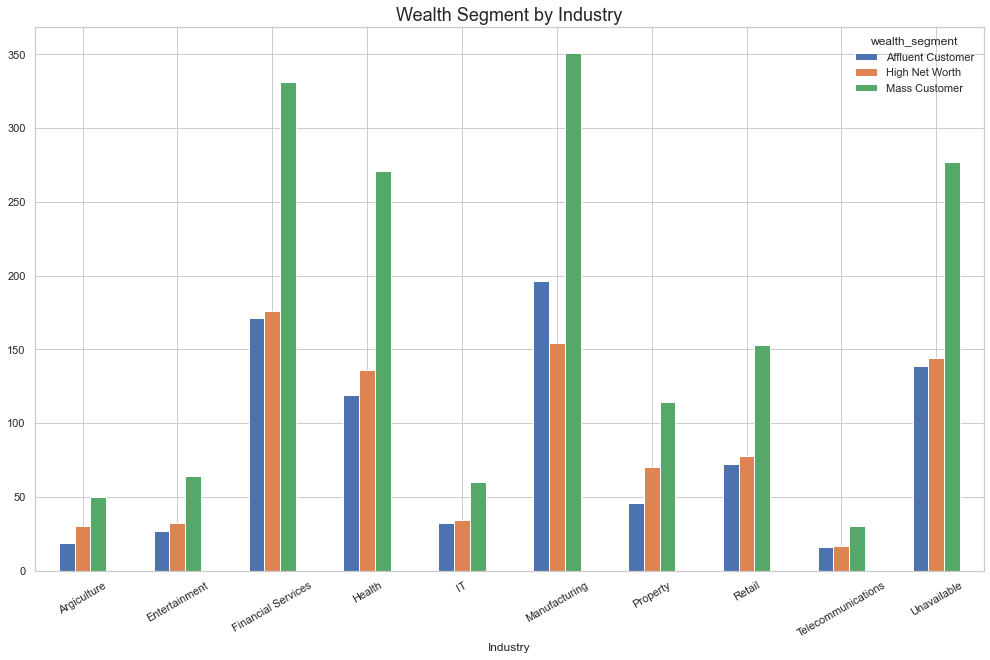

In [919]:
addr_demo_tran.groupby(['job_industry_category','wealth_segment'])[['wealth_segment']].count().dropna().unstack().plot(kind='bar',y='wealth_segment',rot=30,figsize=(17, 10))
plt.xlabel('Industry')
plt.title("Wealth Segment by Industry",fontsize=18)

Text(0.5, 1.0, 'Customer Type by Industry')

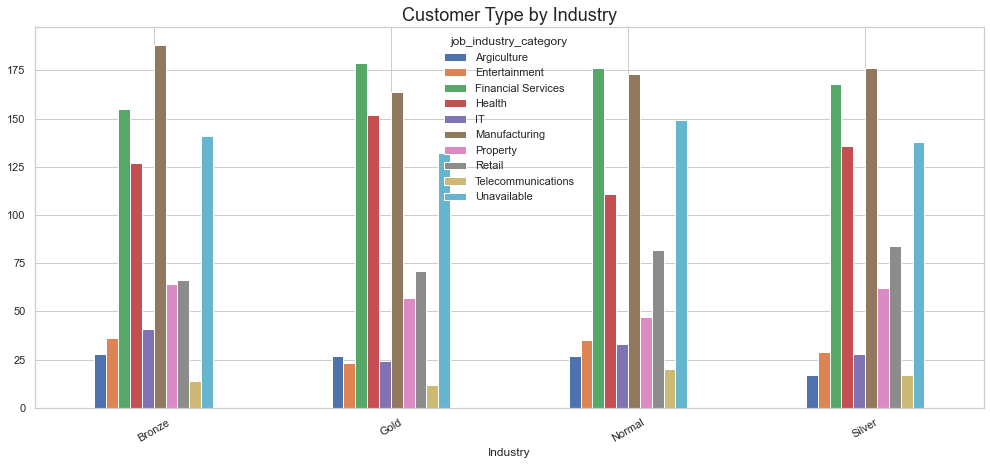

In [947]:
addr_demo_tran.groupby(['Type','job_industry_category'])[['job_industry_category']].count().dropna().unstack().plot(kind='bar',y='job_industry_category',rot=30,figsize=(17, 7))
plt.xlabel('Industry')
plt.title("Customer Type by Industry",fontsize=18)

Text(0.5, 1.0, 'RFM Score by Age')

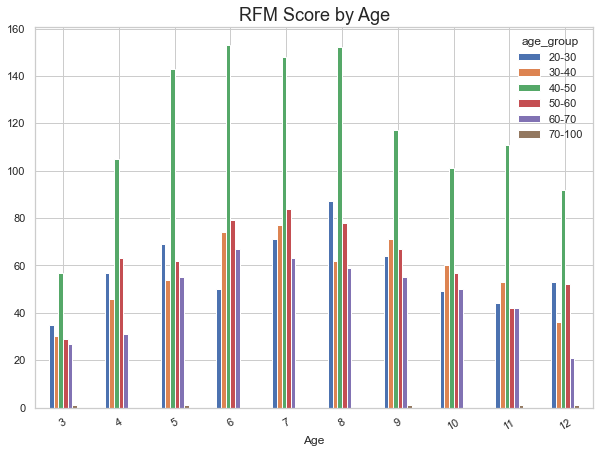

In [956]:
addr_demo_tran.groupby(['total_score','age_group'])['age_group'].count().unstack().plot(kind='bar',rot=30,figsize=(10, 7))
plt.xlabel('Age')
plt.title("RFM Score by Age",fontsize=18)

# Model Building

### Feature Engineering

In [920]:
rfm_rfm = addr_demo_tran[['Recency','Frequency','Moneyness']]
rfm_rfm.describe()

,Recency,Frequency,Moneyness
count,3409.000000,3409.000000,3409.000000
mean,62.727779,5.565562,3062.321660
std,59.324729,2.291390,1748.372954
min,0.000000,1.000000,15.080000
25%,18.000000,4.000000,1795.300000
50%,45.000000,5.000000,2789.250000
75%,87.000000,7.000000,4100.590000
max,353.000000,14.000000,11668.950000


<AxesSubplot:xlabel='Moneyness', ylabel='Count'>

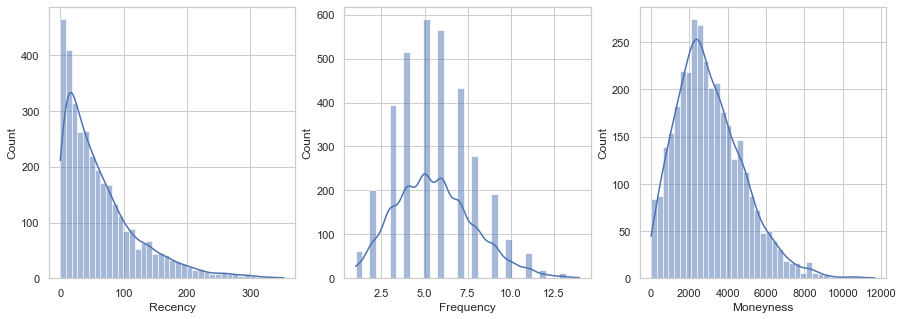

In [921]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(x='Recency', kde=True,data=rfm_rfm, ax=axs[0])
sns.histplot(x='Frequency', kde=True,data=rfm_rfm, ax=axs[1])
sns.histplot(x='Moneyness', kde=True,data=rfm_rfm, ax=axs[2])


We have large value difference in mean, standard deviation etc., which may result in inbalanced weight distribution when calculating the distance and cannot reflect the actual situation, so the data should be standardized.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f879bb28910>,
 'caps': [<matplotlib.lines.Line2D at 0x7f879bb28fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f879bb285b0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f879bb336d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f879bb33a30>,
 'means': []}

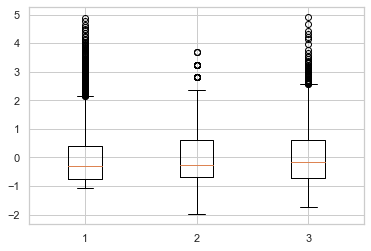

In [922]:
#Normalization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_rfm)

rfm_normalized= scaler.transform(rfm_rfm)

plt.boxplot(rfm_normalized)

### K-mean clustering

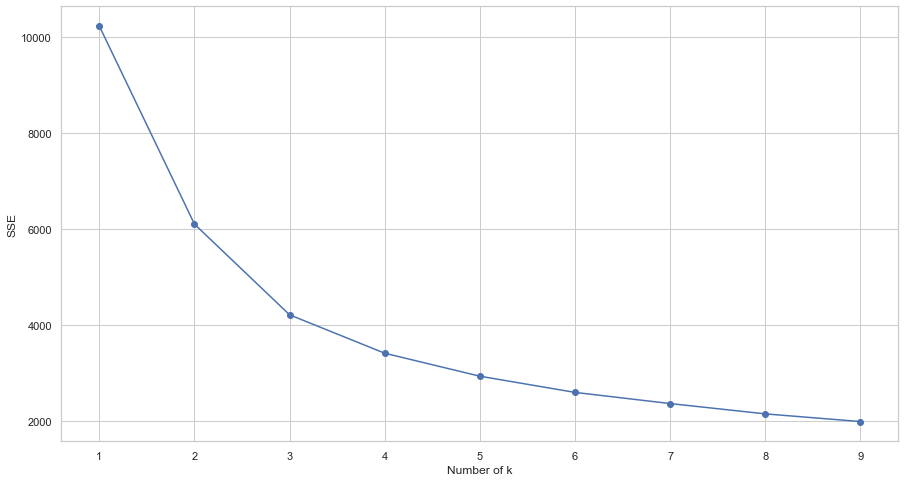

In [923]:

from sklearn.cluster import KMeans

#Use the elbow method to determine the number of clusters
ks = range(1,10)
inertias=[]
for k in ks :#set k to 9， and do kmeans clustering，to see the SSE in different K-value
    kc = KMeans(n_clusters=k,init = 'k-means++',random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)#inertia SSE，the smaller the better，smaller means samples clustered in the mean

# when k changem, how SSE change 
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

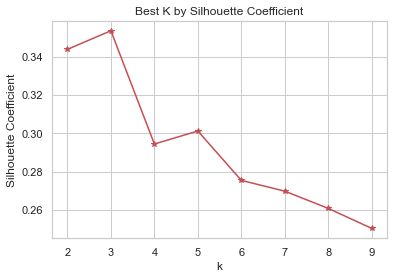

In [924]:
from sklearn.metrics import silhouette_score

K=range(2,10)
score=[]
for k in K:
    kmeans=KMeans(n_clusters=k,random_state=1)
    kmeans.fit(rfm_normalized)
    score.append(silhouette_score(rfm_normalized,kmeans.labels_,metric='euclidean'))
plt.plot(K,score,'r*-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Best K by Silhouette Coefficient')
plt.show()

In [925]:
kc = KMeans(n_clusters= 4, random_state=1)
kc.fit(rfm_normalized)


KMeans(n_clusters=4, random_state=1)

In [926]:
cluster_labels = kc.labels_
cluster_labels

array([1, 3, 3, ..., 2, 2, 3], dtype=int32)

In [927]:
cluster_labels = kc.labels_

#加一列表示是哪个簇
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#计算RFM每个簇的均值、数量:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Moneyness': ['mean', 'count'],}).round(0)

Recency Frequency Moneyness      
             mean      mean      mean count
K_Cluster                                  
0            45.0       4.0    1701.0  1023
1            35.0       9.0    5686.0   599
2            46.0       6.0    3418.0  1288
3           176.0       3.0    1787.0   499

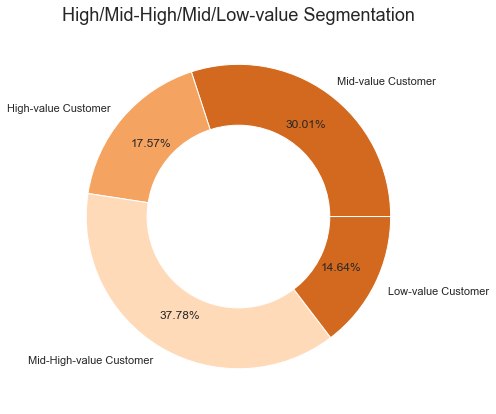

In [949]:
#Pie Chart
class_k=list(kc.labels_)  # Customers by segemnt
percent=[class_k.count(0)/len(rfm_rfm_k3),class_k.count(1)/len(rfm_rfm_k3),class_k.count(2)/len(rfm_rfm_k3),class_k.count(3)/len(rfm_rfm_k3)]   # percentage

fig, ax = plt.subplots(figsize=(7,7))
colors=['chocolate','sandybrown','peachpuff']
types=['Mid-value Customer','High-value Customer','Mid-High-value Customer','Low-value Customer']
ax.pie(percent,radius=1,autopct='%.2f%%',pctdistance=0.75,colors=colors,labels=types)
ax.pie([1], radius=0.6,colors='w')
plt.title('High/Mid-High/Mid/Low-value Segmentation',fontsize=18)
plt.show()

# New Customer

In [929]:
New_Cus.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value', 'age', 'age_group'],
      dtype='object')

<AxesSubplot:xlabel='age_group'>

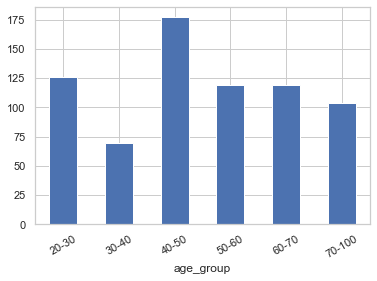

In [932]:
New_Cus.groupby('age_group')['DOB'].count().plot(kind='bar',rot=30)

Text(0.5, 1.0, 'New Customer Wealth Segment by Industry')

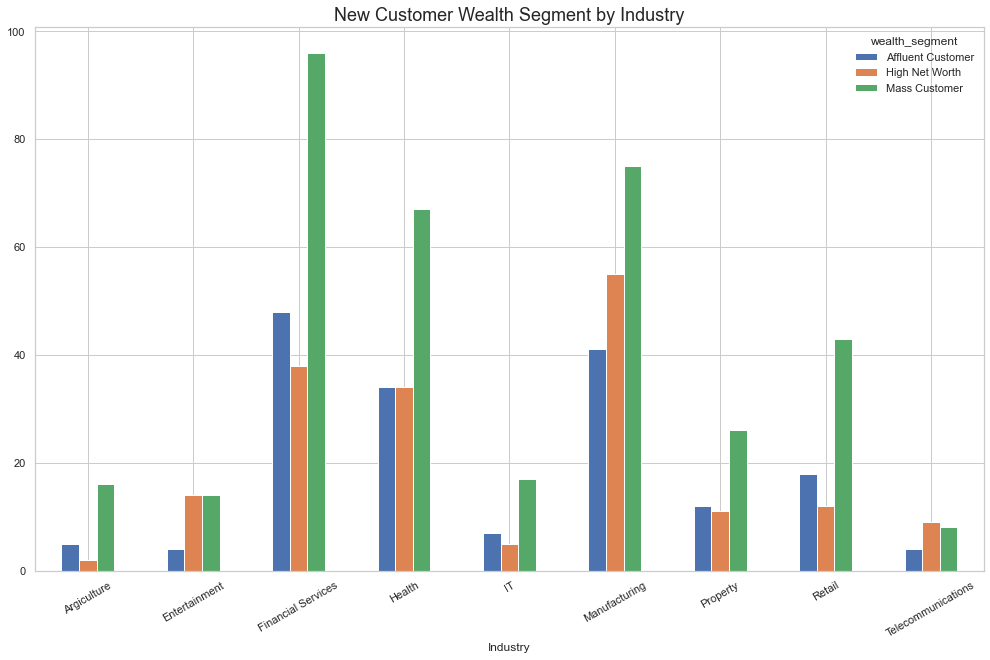

In [934]:
New_Cus.groupby(['job_industry_category','wealth_segment'])[['wealth_segment']].count().dropna().unstack().plot(kind='bar',y='wealth_segment',rot=30,figsize=(17, 10))
plt.xlabel('Industry')
plt.title("New Customer Wealth Segment by Industry",fontsize=18)

In [961]:
rfm_rfm

,Recency,Frequency,Moneyness
customer_id,,,
1,7.0,11,3018.09
2,128.0,3,2226.26
4,195.0,2,220.57
5,16.0,6,2394.94
6,64.0,5,3946.55
...,...,...,...
3496,256.0,4,2045.84
3497,52.0,3,1648.32
3498,127.0,6,3147.33


In [963]:
writer = pd.ExcelWriter('KPMG_final.xlsx',
                        engine = 'xlsxwriter')
addr_demo_tran.to_excel(writer, sheet_name = 'Dataset')
rfm.to_excel(writer, sheet_name = 'RFM')
writer.save()
writer.close()

/Users/elliewu/opt/anaconda3/lib/python3.8/site-packages/xlsxwriter/workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
